# Model Selection and Hyperparameter Tuning

This notebook concerns the [Kaggle's _Human Activity Recognition with Smartphones_ dataset](https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones); it will guide you through the process of selecting the best out of a number of predicting models, and the subsequent process of hyperparameter tuning for that model.

## Loading data

In [1]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('../input/train.csv')
train_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [2]:
train_df.shape

(7352, 563)

In [4]:
X, y = train_df.iloc[:, 0:len(train_df.columns) - 1], train_df.iloc[:, -1]

In [5]:
test_df = pd.read_csv('../input/test.csv')
X_test, y_test = test_df.iloc[:, 0:len(test_df.columns) -1], test_df.iloc[:, -1]

## Predicting Models from scikit-learn

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score # for evaluation

classifiers = [
    DecisionTreeClassifier(),
    KNeighborsClassifier(7), # because there are 6 different labels
    SVC(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = []
scores = []

for clf in classifiers:
    clf = clf.fit(X, y)
    y_pred = clf.predict(X_test)
    
    names.append(clf.__class__.__name__)
    scores.append(accuracy_score(y_pred, y_test))

score_df = pd.DataFrame({'Model': names, 'Score': scores}).set_index('Model')
score_df

/Users/quannguyen/Documents/python/working-projects/kaggle-data/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Score
Model,
DecisionTreeClassifier,0.863929
KNeighborsClassifier,0.807262
SVC,0.930777
GaussianNB,0.770275
QuadraticDiscriminantAnalysis,0.791653


## Accuracy Visualization

[Text(0,0,'DecisionTreeClassifier'),
 Text(0,0,'KNeighborsClassifier'),
 Text(0,0,'SVC'),
 Text(0,0,'GaussianNB'),
 Text(0,0,'QuadraticDiscriminantAnalysis')]

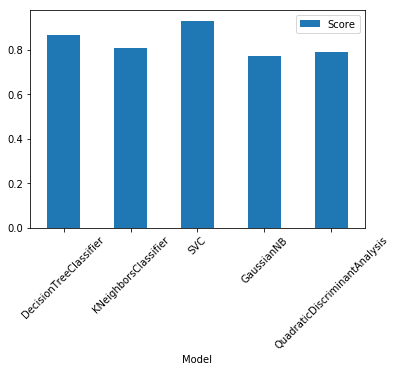

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = score_df.plot.bar()
ax.set_xticklabels(score_df.index, rotation=45, fontsize=10)

Here we see that Support Vector Machine achieves a significantly better score than any other model. We proceed to perform hyperparameter-tuning for SVC, specifically for parameters `kernel` and `C`.

## Hyperparameter Tuning for SVC

### Splitting the Training Set
Here we will split our training set (`X` and `y`) into a sub-training set and a validation set for the process of hyperparameter tuning.

In [15]:
from sklearn.model_selection import train_test_split

# change `test_size` to specify the size of your validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)
X_train.shape, X_test.shape

((6616, 562), (736, 562))

### Hyperparameter Tuning with Grid Search

In [16]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [100, 20, 1, 0.1]
}

selector = GridSearchCV(SVC(), parameters, scoring='accuracy') # we only care about accuracy here
selector.fit(X_train, y_train)

print('Best parameter set found:')
print(selector.best_params_)
print('Detailed grid scores:')
means = selector.cv_results_['mean_test_score']
stds = selector.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, selector.cv_results_['params']):
    print('%0.3f (+/-%0.03f) for %r' % (mean, std * 2, params))
    print()

Best parameter set found:
{'C': 100, 'kernel': 'rbf'}
Detailed grid scores:
0.980 (+/-0.007) for {'C': 100, 'kernel': 'linear'}

0.990 (+/-0.003) for {'C': 100, 'kernel': 'rbf'}

0.982 (+/-0.008) for {'C': 20, 'kernel': 'linear'}

0.987 (+/-0.005) for {'C': 20, 'kernel': 'rbf'}

0.984 (+/-0.006) for {'C': 1, 'kernel': 'linear'}

0.935 (+/-0.018) for {'C': 1, 'kernel': 'rbf'}

0.983 (+/-0.007) for {'C': 0.1, 'kernel': 'linear'}

0.808 (+/-0.018) for {'C': 0.1, 'kernel': 'rbf'}



We see that the parameter combination of `kernel = 'rbf'` and `C = 100` gave the best result. We then use these parameters to perform prediction on the actual testing set.

In [17]:
clf = SVC(kernel='rbf', C=100).fit(X, y)
y_pred = clf.predict(X_test)
print('Accuracy score:', accuracy_score(y_test, y_pred))

Accuracy score: 0.997282608696
